# Exploring the projection matrix

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

from matplotlib.image import imread

%matplotlib notebook

# Utils

In [2]:
def intersect_lines_2d(lines):
    """
    See:
    https://en.wikipedia.org/wiki/Line%E2%80%93line_intersection#In_two_dimensions
    file:///C:/Users/jules/AppData/Local/Temp/silo.tips_least-squares-intersection-of-lines.pdf
    """
    # We define a line as (a, n) where 
    # a is a point on the line
    # n is the direction vector
    S = np.zeros((2,2))
    C = np.zeros((2,))
    for line in lines:
        a = line[0]
        n = line[1] - line[0]
        n = n / np.linalg.norm(n)
        S += np.eye(2) - np.outer(n, n)
        C += (np.eye(2) - np.outer(n, n)) @ a
    
    return np.linalg.pinv(S) @ C.T



In [3]:
# First step: open image and compute matrix
image_path = "../images/table/table.jpg"

<IPython.core.display.Javascript object>


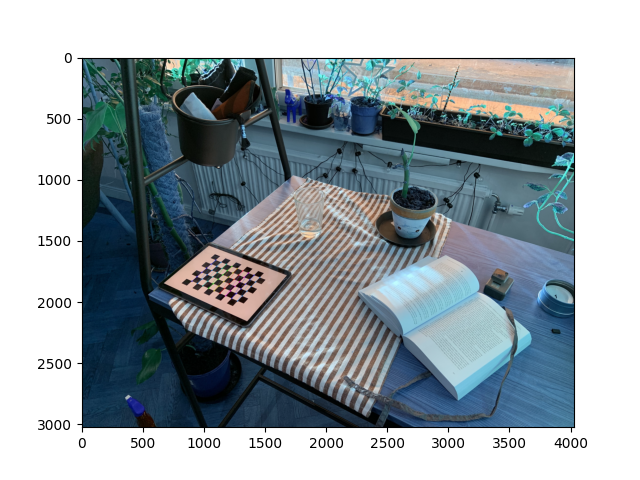

In [4]:
# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
rows, cols = 6, 9
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((rows*cols,3), np.float32)
objp[:,:2] = np.mgrid[0:rows,0:cols].T.reshape(-1,2)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

img = cv.imread(image_path)
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
# Find the chess board corners
ret, corners = cv.findChessboardCorners(gray, (rows, cols), None)
# If found, add object points, image points (after refining them)
if ret == True:
    objpoints.append(objp)
    corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
    imgpoints.append(corners2)

cv.drawChessboardCorners(img, (rows, cols), corners2, ret)
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)    

plt.figure()
plt.imshow(img)
plt.show()

In [5]:
mean_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv.norm(imgpoints[i], imgpoints2, cv.NORM_L2)/len(imgpoints2)
    mean_error += error
print( "total error: {}".format(mean_error/len(objpoints)) )

total error: 0.012821854266108497


In [6]:
img = cv.imread(image_path)
h,  w = img.shape[:2]
newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

In [7]:
dst = cv.undistort(img, mtx, dist, newcameramtx)

<IPython.core.display.Javascript object>


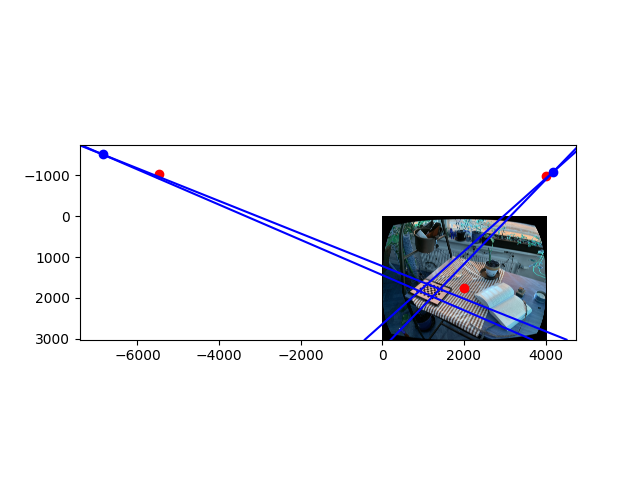

In [8]:
# First property: the columns of P are the vanishing points
img = imread(image_path)
plt.figure()
plt.imshow(dst)

In [9]:
R = cv.Rodrigues(rvecs[0])[0]
t = tvecs[0]
Rt = np.concatenate([R,t], axis=-1) # [R|t]
P = np.matmul(newcameramtx,Rt) # A[R|t]
P = P/P[-1,-1]

for i in range(3):
    plt.scatter(*P[0:2,i]/P[2,i], color = "red")

print(P)

[[ 5.37501250e+01  3.77700143e+01  1.02116937e+02  9.02821866e+02]
 [-1.33257879e+01  7.08530442e+00  8.92517109e+01  1.79973117e+03]
 [ 1.34338825e-02 -6.90045751e-03  5.10191991e-02  1.00000000e+00]]


In [10]:
# Compute vanishing points manually
"""
pt1 = (1094, 1660)
pt2 = (1406, 1782)
pt3 = (898, 1838)
pt4 = (1224, 1972)
"""
"""
pt1 = (1098, 1624)
pt2 = (1410, 1749)
pt3 = (904, 1799)
pt4 = (1227, 1944)
"""
pt1 = (1102, 1661)
pt2 = (1410, 1784)
pt3 = (910, 1832)
pt4 = (1230, 1970)

linesX = [np.array([pt1, pt3]), np.array([pt2, pt4])]
linesY = [np.array([pt1, pt2]), np.array([pt3, pt4])]

X_vp = intersect_lines_2d(linesX)
Y_vp = intersect_lines_2d(linesY)

for line in linesX + linesY:
    plt.axline(line[0], line[1], color = "blue")

plt.scatter(*X_vp, color = "blue")
plt.scatter(*Y_vp, color = "blue")